In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_selection as fs, model_selection, linear_model, tree, ensemble, svm, neighbors, metrics
from skopt import space, gp_minimize
from functools import partial

import logging
import os
import warnings
warnings.filterwarnings('ignore')


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [87]:
data = pd.read_csv("../input/train.csv")
y = data['price_range']
X = data.drop("price_range", axis = 1)

# 1 - Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

- The dataset has no missing values, we can directly move on to EDA without worrying about data cleaning

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data.head())
print(data.shape)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


(2000, 21)


## Impact of ram and battery power on the price_range

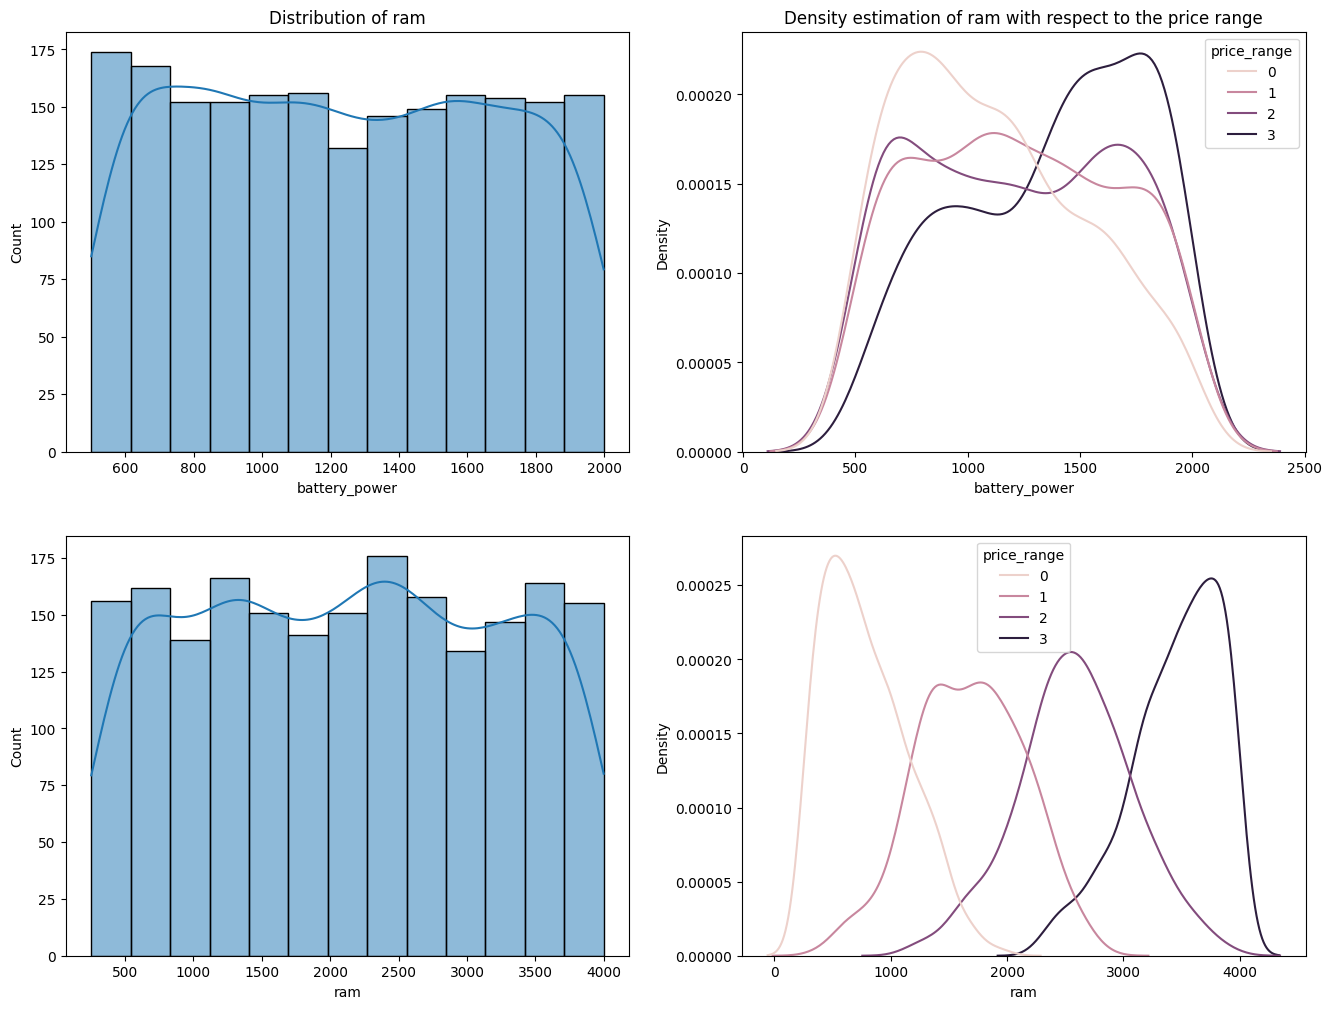

In [5]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
ax = ax.flatten()
sns.histplot(data = data, x = "battery_power", kde = True, ax = ax[0])
sns.kdeplot(data = data, x = "battery_power", hue = "price_range", ax = ax[1])
sns.histplot(data = data, x = "ram", kde = True, ax = ax[2])
sns.kdeplot(data = data, x = "ram", hue = "price_range", ax = ax[3])
ax[0].title.set_text('Distribution of battery power')
ax[1].title.set_text('Density estimation of the battery power with respect to the price range')
ax[0].title.set_text('Distribution of ram')
ax[1].title.set_text('Density estimation of ram with respect to the price range')

- Ram and battery power are 2 of the main technical features of a mobile phone. As one could imagine, they are good predictors for the price range even though their distributions are uniform, the higher both these features are, the higher the price range is.

## Impact of Dual Sim on the price range

Text(0.5, 1.0, "Dual sim's impact on the price range")

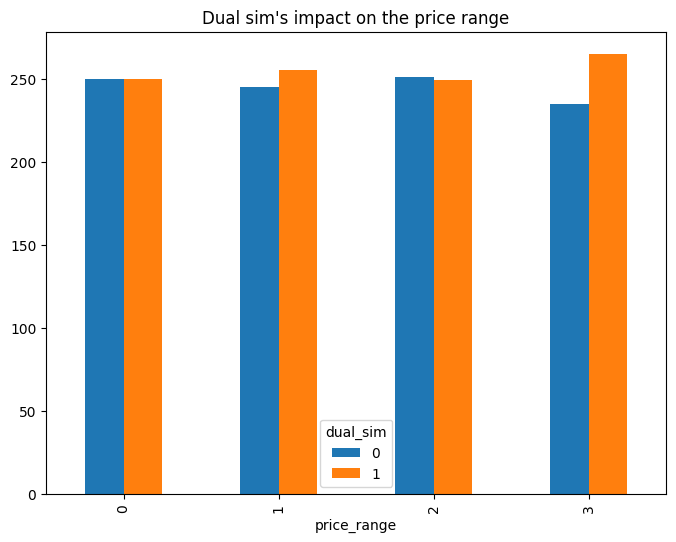

In [6]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
a = pd.crosstab(data["price_range"], data["dual_sim"]).plot.bar(ax = ax)
ax.set_title("Dual sim's impact on the price range")

- Having a dual sim is not as informative as I thought. For higher end mobile phones, there is a slight distinction between those who do have a dual sim and those who don't, clients that are looking for an expensive phone look for this feature a bit more than the others

# 2 - Feature Selection and Engineering

### Distinguishing variable types:
- Ordinal: discrete ordered variables
- Numerical: continous (high cardinality) variables
- Binary: nominal (no order) variables with 2 classes only

In [7]:
data.nunique().sort_values(ascending=False)

ram              1562
px_height        1137
px_width         1109
battery_power    1094
mobile_wt         121
int_memory         63
clock_speed        26
pc                 21
fc                 20
sc_w               19
talk_time          19
sc_h               15
m_dep              10
n_cores             8
price_range         4
blue                2
four_g              2
dual_sim            2
three_g             2
touch_screen        2
wifi                2
dtype: int64

In [8]:
binary_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
ordinal_cols = ['n_cores']
numerical_cols = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
target = ['price_range']
print(set(list(binary_cols + ordinal_cols + target + numerical_cols)) == set(list(data.columns)))

True


### Checking for multicolinearity
- Multicolinearity can help us remove redundant features from the dataset aswell as finding relatonships between features and thus better understanding the dataset

- Using pairplots for numerical variables

In [9]:
# sns.pairplot(data[numerical_cols + target], hue = "price_range")

- Ram and Battery Power seem to be 2 of the most indicative variables, aswell as the dimension variables (screen width & height, pixel width & height)
- Aside these dimension variables, no other variables seem to have high correlation, we can better visualise this using a correlation matrix

## Numerical and Ordinal Features: Heatmap and correlation analysis

<Axes: >

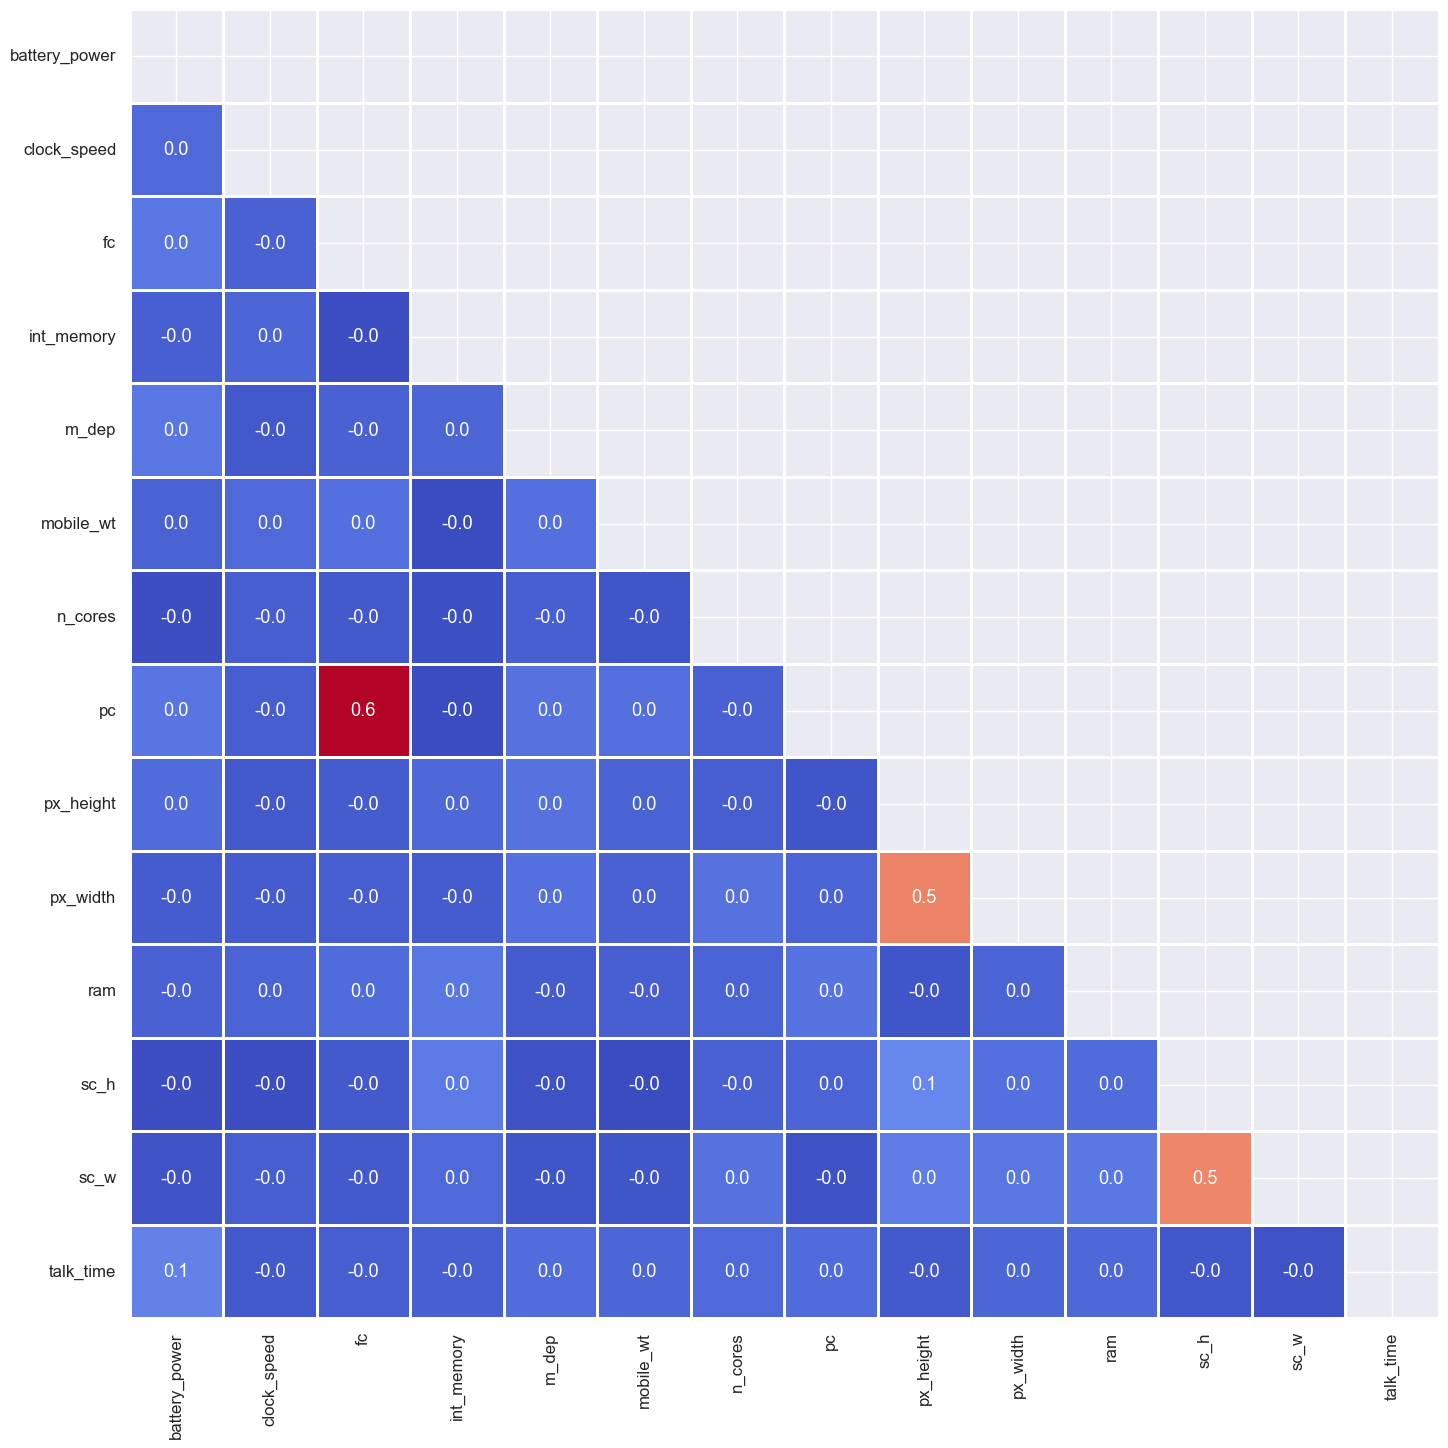

In [10]:
sns.set(font_scale=1.1)
correlation_train = data[numerical_cols].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
annot=True,
fmt='.1f',
cmap='coolwarm',
square=True,
mask=mask,
linewidths=1,
cbar=False)

* Some independant variables are correlated to each other:
  - Which is normal, width and height are likely to be correlated for screen size and pixel resolution
  - Same goes for front camera resolution (fc) and back camera resolution (bc)
* To better see the impact of these correlations, we can compute the Variance Inflation Factor

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = data[numerical_cols].copy()
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X_vif.columns))]
  
display(vif_data.sort_values(by = "VIF", ascending= False))

,feature,VIF
5,mobile_wt,12.526344
9,px_width,11.561984
11,sc_h,11.360273
0,battery_power,7.953793
7,pc,6.217410
13,talk_time,4.835314
10,ram,4.620178
6,n_cores,4.593203
8,px_height,4.238915
1,clock_speed,4.230906


- Scores above 10 are not a good sign, we'll start by merging the width and height variables into an aspect ratio (height/width)

In [12]:
print(X_vif.loc[X_vif["px_width"] == 0].shape[0])
print(X_vif.loc[X_vif["sc_w"] == 0].shape[0])

0
180


- Some screen widths are equal to 0, this is physically impossible and probably a forgotten measure
- Let's check if the corresponding heights can give us insights on why the data is missing

2023-10-05 15:05:14,454 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-05 15:05:14,462 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='sc_h', ylabel='sc_w'>

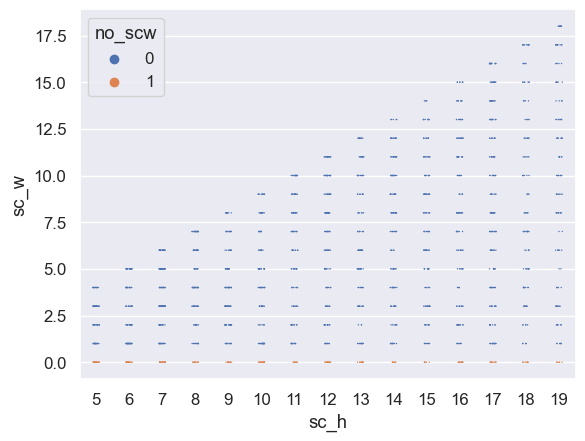

In [13]:
X_vif = data[numerical_cols].copy()
X_vif["no_scw"] = X_vif.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
sns.stripplot(data = X_vif, x = "sc_h", y = "sc_w", hue= "no_scw", size = 1)

- No clear patterns, we'll keep the the flag for missing values and impute the 0 with the mode of the corresponding group of heights

2023-10-05 15:05:14,787 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-05 15:05:14,795 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='sc_h', ylabel='sc_w'>

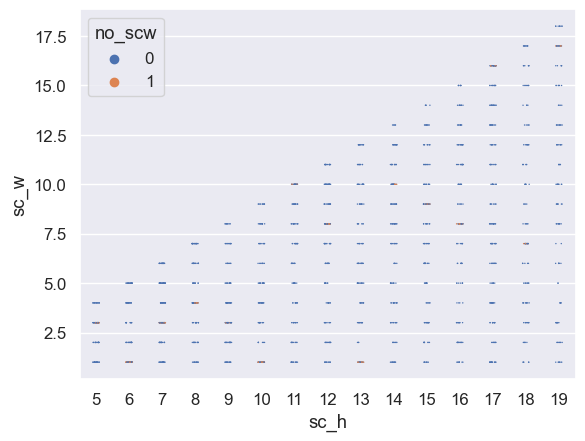

In [14]:
imputation_dict = {}
for height in list(X["sc_h"].unique()):
    imputation_dict[str(height)] = X_vif.loc[X_vif["sc_h"] == height, "sc_w"].mode().values[0]

def null_width(row):
    if row["sc_w"] == 0:
        return imputation_dict[str(row["sc_h"].astype("int"))]
    else:
        return row["sc_w"]

X_vif = data[numerical_cols].copy()
X_vif["no_scw"] = X_vif.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
X_vif["sc_w"] = X_vif.apply(null_width, axis = 1)
sns.stripplot(data = X_vif, x = "sc_h", y = "sc_w", hue= "no_scw", size = 1)

- The zero width rows are distributed within each height category, we can compute the aspect ratios

In [15]:
X_vif["aspect_ratio"] = X_vif["sc_h"]/X_vif["sc_w"]
X_vif["pixel_ratio"] = X_vif["px_height"]/X_vif["px_width"]
X_vif.drop(["sc_h", "sc_w", "px_height", "px_width"], axis = 1, inplace= True)
logger.info(display(X_vif))
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
  
display(vif_data.sort_values(by = "VIF", ascending= False))

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,no_scw,aspect_ratio,pixel_ratio
0,842,2.2,1,7,0.6,188,2,2,2549,19,0,1.285714,0.026455
1,1021,0.5,0,53,0.7,136,3,6,2631,7,0,5.666667,0.455231
2,563,0.5,2,41,0.9,145,5,6,2603,9,0,5.500000,0.736014
3,615,2.5,0,10,0.8,131,6,9,2769,11,0,2.000000,0.680851
4,1821,1.2,13,44,0.6,141,2,14,1411,15,0,4.000000,0.996700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,0.5,0,2,0.8,106,6,14,668,19,0,3.250000,0.646561
1996,1965,2.6,0,39,0.2,187,4,3,2032,16,0,1.100000,0.465649
1997,1911,0.9,1,36,0.7,108,8,3,3057,5,0,9.000000,0.531863
1998,1512,0.9,4,46,0.1,145,5,5,869,19,0,1.800000,0.501493


2023-10-05 15:05:15,056 - __main__ - INFO - None


,feature,VIF
5,mobile_wt,11.786723
0,battery_power,7.802831
7,pc,6.167216
9,talk_time,4.772771
8,ram,4.529254
6,n_cores,4.451668
1,clock_speed,4.204607
12,pixel_ratio,3.931280
4,m_dep,3.868886
3,int_memory,3.842852


- We still have some high VIFs, but will use another criterion to select the best features

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,aspect_ratio,pixel_ratio
F statistic,3.159816e+01,0.493708,0.772182,2.922996,1.500682,3.594318,2.625415,0.825446,3520.110824,1.628811,1.370389,4.170231
p-value,5.948688e-20,0.686675,0.509504,0.032777,0.212459,0.013117,0.048936,0.479749,0.000000,0.180669,0.250039,0.005922


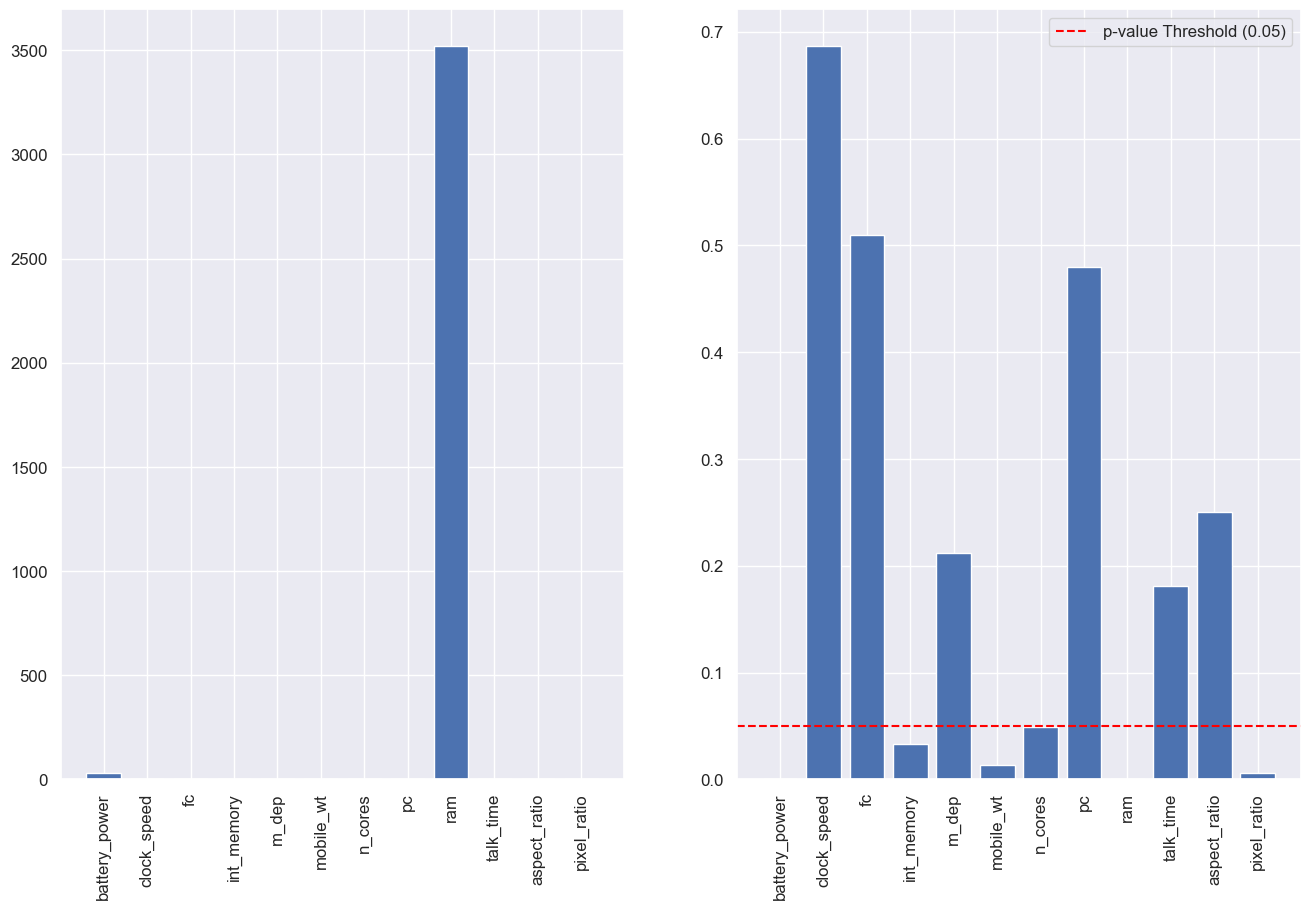

In [16]:
from sklearn import feature_selection as fs
X_anova_f = X_vif.drop("no_scw", axis = 1)
f_stat_kb = fs.SelectKBest(score_func=fs.f_classif, k='all')
f_stat_kb.fit(X_anova_f, y)
X_fs = f_stat_kb.transform(X_anova_f)
display(pd.DataFrame([f_stat_kb.scores_, f_stat_kb.pvalues_], columns=X_anova_f.columns, index=["F statistic", "p-value"]))
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax = ax.flatten()
ax[0].bar(range(len(f_stat_kb.scores_)), f_stat_kb.scores_)
ax[0].set_xticks(range(len(f_stat_kb.scores_)))
ax[0].set_xticklabels(X_anova_f.columns, rotation=90)
ax[1].bar(range(len(f_stat_kb.pvalues_)), f_stat_kb.pvalues_)
ax[1].set_xticks(range(len(f_stat_kb.pvalues_)))
ax[1].set_xticklabels(X_anova_f.columns, rotation=90)
ax[1].axhline(y=0.05, color='red', linestyle='--', label=f'p-value Threshold (0.05)')
ax[1].legend()
plt.show()

* Ram is by far the best predictor in terms of the between groups variance just like we saw in the previous histograms.
* Using a p-value threshold of 0.05, we would select the 6 best predictors as follows
    - ram
    - mobile_wt
    - int_memory
    - n_cores
    - pixel_ratio
    - battery_power
* We can also retry computing the vif scores

In [17]:
X_vif2 = X_vif.drop("no_scw", axis = 1)
f_stat_kb = fs.SelectKBest(score_func=fs.f_classif, k=6)
f_stat_kb.fit(X_vif2, y)
X_vif2 = pd.DataFrame(f_stat_kb.transform(X_vif2), columns = f_stat_kb.get_feature_names_out())

In [18]:
vif_data2 = pd.DataFrame()
vif_data2["feature"] = X_vif2.columns
vif_data2["VIF"] = [variance_inflation_factor(X_vif2.values, i)
                          for i in range(len(X_vif2.columns))]
  
display(vif_data2.sort_values(by = "VIF", ascending= False))

,feature,VIF
2,mobile_wt,9.905977
0,battery_power,7.118030
4,ram,4.380788
3,n_cores,4.310017
5,pixel_ratio,3.869158
1,int_memory,3.760204


- All vif scores are below 10 which will be accepted for now as a threshold, however if the model doesn't perform well, the still present multicolinearity might be a potential issue, especially since no visible relationship is visible

In [19]:
# sns.pairplot(pd.concat([X_vif2, y], axis = 1), hue = "price_range")

## Binary features: chi2 independance test

In [20]:
X_2 = X.copy()
binary_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'no_scw']
X_2["no_scw"] = X_2.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
X_2 = X_2[binary_cols]
X_2

,blue,dual_sim,four_g,three_g,touch_screen,wifi,no_scw
0,0,0,0,0,0,1,0
1,1,1,1,1,1,0,0
2,1,1,1,1,1,0,0
3,1,0,0,1,0,0,0
4,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...
1995,1,1,1,1,1,0,0
1996,1,1,0,1,1,1,0
1997,0,1,1,1,1,0,0
1998,0,0,1,1,1,1,0


2023-10-05 16:26:26,859 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


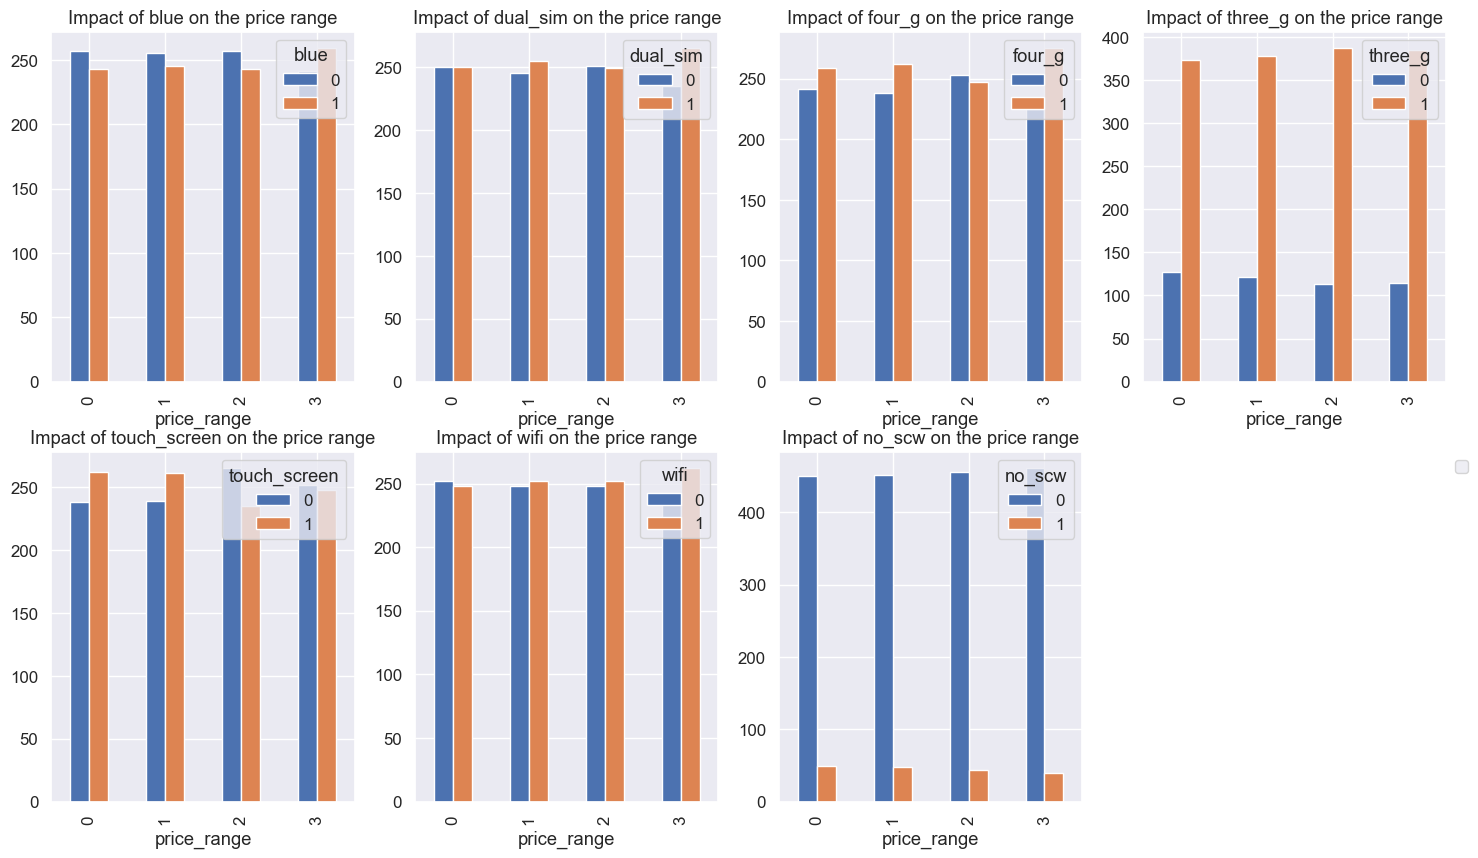

In [96]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10))
for axis, col in zip(ax.flatten()[:-1], list(X_2.columns)):
    pd.crosstab(y, X_2[col]).plot.bar(ax=axis)
    axis.set_title(f"Impact of {col} on the price range")

#Leave the last subplot empty
ax[-1, -1].axis('off')

- Seems like none of the binary variables are good predictors, let's test this statistically

,blue,dual_sim,four_g,three_g,touch_screen,wifi,no_scw
F statistic,0.723232,0.631011,1.521572,0.327643,1.928429,0.422091,1.377778
p-value,0.867726,0.889298,0.677300,0.954748,0.587394,0.935642,0.710752


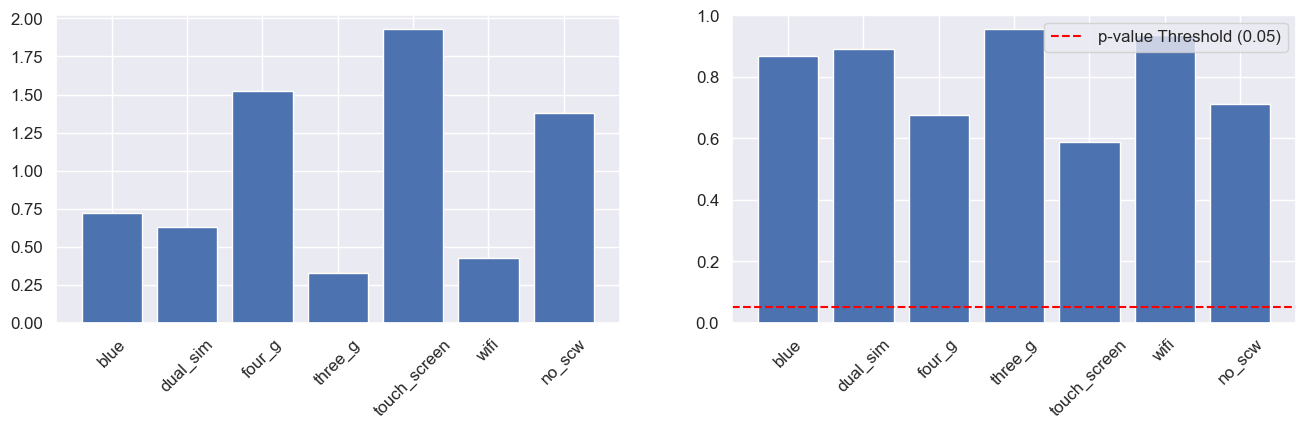

In [22]:
from sklearn import feature_selection as fs
f_stat_chi2 = fs.SelectKBest(score_func=fs.chi2, k='all')
f_stat_chi2.fit(X_2, y)
X_chi2 = f_stat_chi2.transform(X_2)
display(pd.DataFrame([f_stat_chi2.scores_, f_stat_chi2.pvalues_], columns=X_2.columns, index=["F statistic", "p-value"]))
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax = ax.flatten()
ax[0].bar(range(len(f_stat_chi2.scores_)), f_stat_chi2.scores_)
ax[0].set_xticks(range(len(f_stat_chi2.scores_)))
ax[0].set_xticklabels(X_2.columns, rotation=45)
ax[1].bar(range(len(f_stat_chi2.pvalues_)), f_stat_chi2.pvalues_)
ax[1].set_xticks(range(len(f_stat_chi2.pvalues_)))
ax[1].set_xticklabels(X_2.columns, rotation=45)
ax[1].axhline(y=0.05, color='red', linestyle='--', label=f'p-value Threshold (0.05)')
ax[1].legend()
plt.show()

- The Chi2 test for independance isn't rejected for any variable just like we suspected, meaning that they are just no informative enough

## Recursive Feature Elimination

- Whilst using these statistical tests can give good insights on which variables are good or bad predictors, it doesn't look the effect of the combinations between variables. Let us use Recursive Feature Elimination to confirm this

In [123]:
X = data.drop('price_range', axis=1)
y = data['price_range']

imputation_dict = {}
for height in list(X["sc_h"].unique()):
    imputation_dict[str(height)] = X.loc[X["sc_h"] == height, "sc_w"].mode().values[0]

def null_width(row):
    if row["sc_w"] == 0:
        return imputation_dict[str(row["sc_h"].astype("int"))]
    else:
        return row["sc_w"]

X["no_scw"] = X.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
X["sc_w"] = X.apply(null_width, axis = 1)
X["aspect_ratio"] = X["sc_h"]/X["sc_w"]
X["pixel_ratio"] = X["px_height"]/X["px_width"]

In [145]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

rfe_models = [ensemble.RandomForestClassifier(), tree.DecisionTreeClassifier()]

result_dict = {}
for model in rfe_models:
    rf_classifier = model
    rfe = fs.RFE(estimator=model, n_features_to_select=None)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    rf_classifier.fit(X_train_rfe, y_train)
    X_test_rfe = rfe.transform(X_test)
    y_pred = rf_classifier.predict(X_test_rfe)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    result_dict[str(model)] = [f for f, mask in zip(X_train.columns, rfe.support_) if mask]

selected_features = pd.DataFrame.from_dict(result_dict, orient='index', columns=[f'Feature {i+1}' for i in range(max(map(len, result_dict.values())))])
selected_features.index = ["Random Forest", "Decision Tree"]
display(selected_features)

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11
Random Forest,battery_power,int_memory,mobile_wt,pc,px_height,px_width,ram,sc_h,talk_time,aspect_ratio,pixel_ratio
Decision Tree,battery_power,clock_speed,fc,mobile_wt,n_cores,pc,px_height,px_width,ram,aspect_ratio,pixel_ratio


- We do find within the 2 selected models for the RFE the prevalent anova f-test features and no binary ones. To avoid dropping any informative features, we will keep all numerical features until further analysis

# 3 - Data Preprocessing

* Let's put all our work together in a single pipeline:
    - Custom imputation of the screen width values (0 is considerend a missing value)
    - Feature engineering of 2 variables (aspect_ratio and px_ratio), subsequent removal of the old features to avoid multicolinearity
    - Feature selection using the variables found earlier
    - Standardizing the data since the scales are quite different (for logistic regression)

In [23]:
ordinal_cols = ['n_cores']
numerical_cols = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'ram', 'talk_time']
target = ['price_range']

In [169]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import metrics
#https://stackoverflow.com/questions/62585623/custom-transformer-using-baseestimator-transformermixin

#Creating custom imputation methods for our pipeline
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X_temp = X.copy()
        try:
            self.imputation_dict = {
                height: X_temp.loc[X['sc_h'] == height, 'sc_w'].mode().values[0]
                for height in X_temp['sc_h'].unique()
            }
            self.imputation_dict["safety"] = X_temp['sc_h'].mode().values[0]
        except KeyError:
            pass
        return self
    
    def transform(self, X):
        X_temp = X.copy()
        mask = (X_temp['sc_w'] == 0)
        try:
            X_temp['sc_w'] = np.where(mask, X_temp['sc_h'].map(self.imputation_dict), X_temp['sc_w'])
        except Exception as e:
            print(e)
            X_temp['sc_w'] = self.imputation_dict["safety"]
        return X_temp
    
#Feature engineering and removal of old dimension variables
class DimensionVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["aspect_ratio"] = X["sc_h"]/X["sc_w"]
        X["pixel_ratio"] = X["px_height"]/X["px_width"]
        #X.drop(["sc_h", "sc_w"], axis = 1, inplace= True)
        X.drop(["sc_h", "sc_w", "px_height", "px_width"], axis = 1, inplace= True)
        return X
    
def define_pipeline(model=None, tree = False):
    """
    Function to create a pipeline with a certain model as an argument
    If no model is passed, only the preprocessing steps are instanciated
    """
    preprocessing_steps = [
        ('custom_imputer', CustomImputer()),
        ('aspect_and_pixel_ratio', DimensionVariables()),
    ]

    if not tree:
        preprocessing_steps.append(('standardizer', preprocessing.StandardScaler()))
    
    if model is not None:
        preprocessing_steps.append((f"model_{str(model).split('(')[0]}", model))
    
    pipeline = Pipeline(preprocessing_steps)
    return pipeline

In [178]:
y = data["price_range"]
X = data.drop("price_range", axis = 1, inplace=False)
X["no_scw"] = X.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
X = X[numerical_cols+ordinal_cols]

In [179]:
define_pipeline()

Pipeline(steps=[('custom_imputer', CustomImputer()),
                ('aspect_and_pixel_ratio', DimensionVariables()),
                ('standardizer', StandardScaler())])

In [180]:
prep = define_pipeline(tree=True)
X_prep_test = prep.fit_transform(X.copy(),y)
display(X_prep_test)

KeyError: 'sc_w'

# 4 - Model Building

In [90]:
#Function to display confusion matrices

def modified_confusion_matrix(y_pred, y_val, model_name):
    cm = metrics.confusion_matrix(y_pred, y_val)

    scores_df = pd.DataFrame(metrics.precision_recall_fscore_support(y_pred, y_val)).T
    scores_df.columns = ["precision", "recall", "fscore", "support"]
    scores_df[['precision', 'recall', 'fscore']] = scores_df[['precision', 'recall', 'fscore']] * 100
    scores_df = scores_df.round({'precision': 2, 'recall': 2, 'fscore': 2})
    overall_accuracy = "{:.2%}".format(metrics.accuracy_score(y_pred, y_val))
    res = pd.concat([pd.DataFrame(cm), scores_df['recall']], axis = 1)
    res = pd.concat([res, scores_df['precision'].to_frame().T], axis = 0)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    heatmap = sns.heatmap(res, annot=True, fmt='g', cmap="YlOrRd", cbar_kws={'shrink': 0.8})
    ax.set_xticklabels([str(i) for i in range(4)] + ["Recall"])
    ax.set_yticklabels([str(i) for i in range(4)] + ["Precision"])
    ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)
    plt.ylabel('Predicted Labels')
    ax.set_title(f"Confusion Matrix for the {model_name} Model " + f"({overall_accuracy} accuracy)" + '\n' + '\n' + r"True Labels", multialignment='center')
    ax.set_frame_on(False)
    plt.show()

For the rest of the analysis, a 5 fold cross validation metric will be used, if a confusion matrix is shown, it has been obtained from a classic train test split (80% test)

## 1 - Logistic Regression

Average model score over 5 folds: 82.40%


Pipeline(steps=[('custom_imputer', CustomImputer()),
                ('aspect_and_pixel_ratio', DimensionVariables()),
                ('feature_selection',
                 ColumnTransformer(transformers=[('numerical_ordinal',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'pc', 'ram',
                                                   'talk_time', 'n_cores']),
                                                 ('binary',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr(score_func=<function chi2 at 0x000001A6AAEBF6A0>))]),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi', 'no_scw'])])),
                ('standardizer', StandardScaler()),
                ('model_LogisticRegression', LogisticRegression())])

This treeview is honestly beautiful


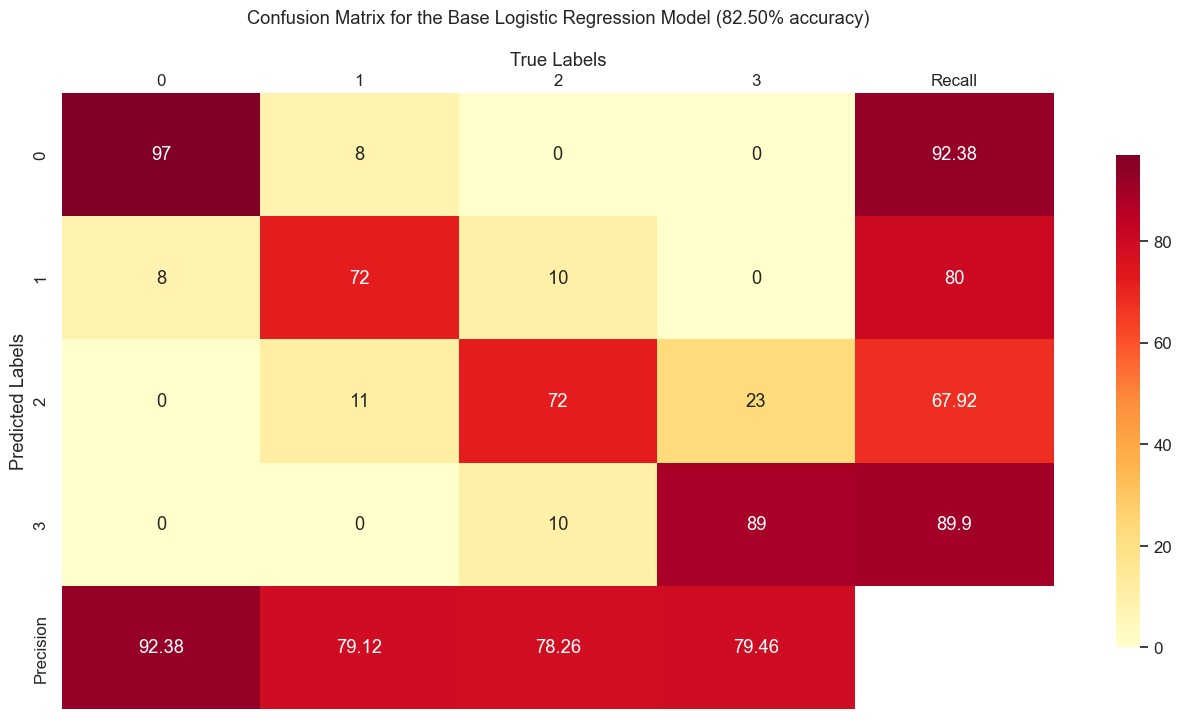

In [91]:
X_train, X_val, y_train, y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)
LR = define_pipeline(linear_model.LogisticRegression(), tree=False)
cv_score = "{:.2%}".format(model_selection.cross_val_score(LR, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(LR)
print("This treeview is honestly beautiful")
LR.fit(X_train, y_train)
y_pred = LR.predict(X_val)

modified_confusion_matrix(y_pred, y_val, "Base Logistic Regression")

- Hyperparameter tuning is worth a try, even if (Logistic Regression doesn't have that many hyperparameters):

Average model score over 5 folds: 82.30%


Pipeline(steps=[('custom_imputer', CustomImputer()),
                ('aspect_and_pixel_ratio', DimensionVariables()),
                ('feature_selection',
                 ColumnTransformer(transformers=[('numerical_ordinal',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'pc', 'ram',
                                                   'talk_time', 'n_cores']),
                                                 ('binary',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr(score_func=<function chi2 at 0x000001A6AAEBF6A0>))]),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi', 'no_scw'])])),
                ('standardizer', StandardScaler()),
                ('model_LogisticRegression', LogisticRegression())])

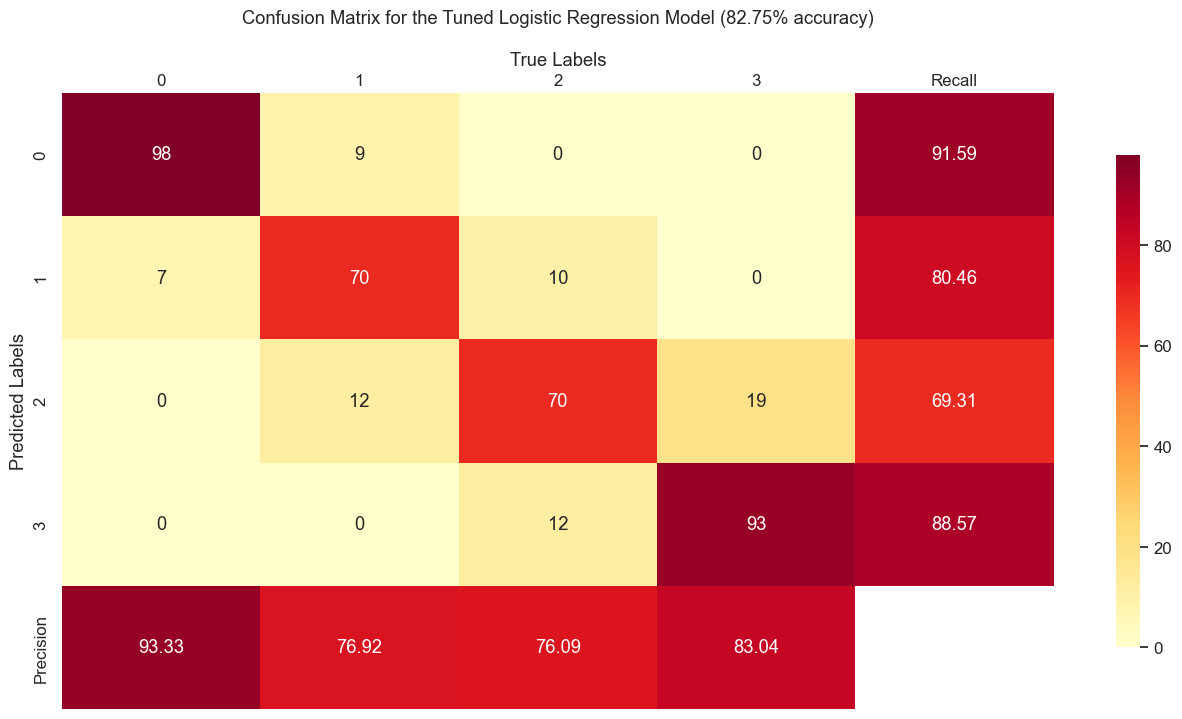

In [92]:
X_train, X_val, y_train ,y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)

param_LR= {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2']}
folds_LR = model_selection.StratifiedKFold(n_splits = 4, shuffle = True)
tuned_model_LR = model_selection.GridSearchCV(linear_model.LogisticRegression(),
                                           param_grid=param_LR,
                                           cv=folds_LR)
LR_hyper = define_pipeline(tuned_model_LR, tree=False)
cv_score = "{:.2%}".format(model_selection.cross_val_score(LR_hyper, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(LR)
LR_hyper.fit(X_train, y_train)
y_pred = LR_hyper.predict(X_val)

modified_confusion_matrix(y_pred, y_val, "Tuned Logistic Regression")

- Couldn't improve on it, let's try out a different model

## 2 - Decision Tree

### a - Randomized Grid Search

In [93]:
X_train, X_val, y_train ,y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)

param_DT = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(2, 20)),
    'min_samples_split': list(range(2, 20)),
    'min_samples_leaf': list(range(2, 20)),
    'max_features': [None]
}
folds_DT = model_selection.StratifiedKFold(n_splits = 5)
tuned_model_DT = model_selection.RandomizedSearchCV(tree.DecisionTreeClassifier(),
                                           param_distributions=param_DT,
                                           cv=folds_DT, n_iter = 500)
DT_hyper = define_pipeline(tuned_model_DT, tree=True)
cv_score = "{:.2%}".format(model_selection.cross_val_score(DT_hyper, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(DT_hyper)
DT_hyper.fit(X_train, y_train)
y_pred = DT_hyper.predict(X_val)

DT_best = print(DT_hyper['model_RandomizedSearchCV'].best_params_)

#modified_confusion_matrix(y_pred, y_val, "Random Grid DT")

Average model score over 5 folds: 78.50%


Pipeline(steps=[('custom_imputer', CustomImputer()),
                ('aspect_and_pixel_ratio', DimensionVariables()),
                ('feature_selection',
                 ColumnTransformer(transformers=[('numerical_ordinal',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'pc', 'ram',
                                                   'talk_time', 'n_cores']),
                                                 ('binary',
                                                  Pipeline(step...
                 RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                    estimator=DecisionTreeClassifier(),
                                    n_iter=500,
                                    param_distributions={'criterion': ['gini',
                                                                       'entropy'],
                                                         'max_depth': [2, 3, 4,
                                                                       5, 6, 7,
                                                                       8, 9, 10,
                                                                       11, 12,
                                                                       13, 14,
                                                                       15, 16,
                                                                       17, 18,
                                                                       19],
                                                         'max_features': [None],
                                                         'min_samples_leaf': [2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              11,
                                                                              12,
                                                                              13,
                                                                              14,
                                                                              15,
                                                                              16,
                                                                              17,
                                                                              18,
                                                                              19],
                                                         'min_samples_split': [2,
                                                                               3,
                                                                               4,
                                                                               5,
                                                                               6,
                                                                               7,
                                                 

{'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}


### b - Exhaustive Grid Search

In [31]:
X_train, X_val, y_train ,y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)

param_DT_exhaustive = {
    'criterion': ['gini'],
    'splitter': ['random'],
    'max_depth': list(range(10, 20)),
    'min_samples_split': list(range(2, 4)),
    'min_samples_leaf': list(range(7, 14)),
    'max_features': [None]
}
folds_DT = model_selection.StratifiedKFold(n_splits = 5,)
tuned_model_DT_exhaustive = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),
                                           param_grid=param_DT_exhaustive,
                                           cv=folds_DT)
DT_hyper_exhaustive = define_pipeline(tuned_model_DT_exhaustive, True)
cv_score = "{:.2%}".format(model_selection.cross_val_score(DT_hyper_exhaustive, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(DT_hyper_exhaustive)
DT_hyper_exhaustive.fit(X_train, y_train)
y_pred = DT_hyper_exhaustive.predict(X_val)

DT_best = print(DT_hyper_exhaustive['model_GridSearchCV'].best_params_)

#modified_confusion_matrix(y_pred, y_val, "Tuned Decision Tree")

Average model score over 5 folds: 80.35%


Pipeline(steps=[('custom_imputer', CustomImputer()),
                ('aspect_and_pixel_ratio', DimensionVariables()),
                ('feature_selection',
                 ColumnTransformer(transformers=[('numerical_ordinal',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'pc', 'ram',
                                                   'talk_time', 'n_cores']),
                                                 ('binary',
                                                  Pipeline(step...
                                                   'three_g', 'touch_screen',
                                                   'wifi', 'no_scw'])])),
                ('model_GridSearchCV',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini'],
                                          'max_depth': [10, 11, 12, 13, 14, 15,
                                                        16, 17, 18, 19],
                                          'max_features': [None],
                                          'min_samples_leaf': [7, 8, 9, 10, 11,
                                                               12, 13],
                                          'min_samples_split': [2, 3],
                                          'splitter': ['random']}))])

{'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 13, 'min_samples_split': 2, 'splitter': 'random'}


- Slightly worse than the Logistic Regression Model, having only numerical features (and no binary ones) might have hindered it

## 3 - Random Forest

### Bayesian optimization:

- Since computation time is too costly (a lot of hyperparameter combinations for a random forest), we'll use skopt to tune the model, the gp_minimize is commented out to avoid computing a second time

In [32]:
def optimize(params, param_names, X, y):
    params = dict(zip(param_names, params))
    RF_bo = define_pipeline(ensemble.RandomForestClassifier(**params), tree=True)
    display(RF_bo)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=X, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = X.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        xtest = X.iloc[test_idx]
        ytest = y.iloc[test_idx]
        RF_bo.fit(xtrain, ytrain)
        preds = RF_bo.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)
    return -1.0 * np.mean(accuracies)

param_space = [
    space.Categorical([True, False], name='bootstrap'),
    space.Integer(10, 100, name='max_depth'),
    space.Real(0.01, 1, prior="uniform", name='max_features'),
    space.Integer(1, 4, name='min_samples_leaf'),
    space.Integer(2, 10, name='min_samples_split'),
    space.Integer(200, 2000, name='n_estimators')
]

param_name = [item.name for item in param_space]

optimization_function = partial(optimize, param_names=param_name, X=X, y=y)

# result = gp_minimize(
#     optimization_function,
#     dimensions=param_space,
#     n_calls=10,
#     n_random_starts=10,
#     verbose=10
# )

# print(dict(zip(param_name, result.x)))

import pickle
# pickle.dump({"Best_RF": dict(zip(param_name, result.x))}, open('RF' + ".p", "wb" ) )

with open("../src/RF.p", 'rb') as pickled:
    data = pickle.load(pickled)
    RF_tuned = data["Best_RF"]

RF_best = define_pipeline(ensemble.RandomForestClassifier(**RF_tuned), tree=True)
cv_score = "{:.2%}".format(model_selection.cross_val_score(RF_best, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(RF_best)

Average model score over 5 folds: 81.20%


Pipeline(steps=[('custom_imputer', CustomImputer()),
                ('aspect_and_pixel_ratio', DimensionVariables()),
                ('feature_selection',
                 ColumnTransformer(transformers=[('numerical_ordinal',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'pc', 'ram',
                                                   'talk_time', 'n_cores']),
                                                 ('binary',
                                                  Pipeline(steps=[('anova_f_classif',
                                                                   SelectFpr(score_func=<function chi2 at 0x000001A6AAEBF6A0>))]),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi', 'no_scw'])])),
                ('model_RandomForestClassifier',
                 RandomForestClassifier(max_depth=60,
                                        max_features=0.596609665874316,
                                        min_samples_split=9,
                                        n_estimators=1065))])

- Better than the Decision Tree model but only slightly, still worse than logistic regression

In [61]:
RF = ensemble.RandomForestClassifier()
kf = model_selection.KFold(n_splits=5)
scores = model_selection.cross_val_score(RF, X, y, cv=5)
scores

array([0.8725, 0.8725, 0.905 , 0.8475, 0.8525])

In [62]:
DT = tree.DecisionTreeClassifier()
kf = model_selection.KFold(n_splits=5)
scores = model_selection.cross_val_score(RF, X, y, cv=5)
scores

array([0.87  , 0.8775, 0.885 , 0.8725, 0.84  ])

In [80]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,train_size=0.8,random_state=42)

In [81]:
# Init the transformer
rfe = fs.RFE(estimator=ensemble.RandomForestRegressor(), n_features_to_select=None)

# Fit to the training data
_ = rfe.fit(X_train, y_train)

In [82]:
X_train.loc[:, rfe.support_]

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,pc,px_height,px_width,ram,talk_time
968,1923,0.5,46,0.5,191,10,767,1759,1489,3
240,633,2.2,49,0.1,139,1,529,1009,3560,16
819,1236,0.9,57,0.1,188,14,517,809,1406,20
692,781,1.1,38,0.4,198,7,304,1674,3508,5
420,1456,0.5,7,0.4,105,12,823,1104,1587,20
...,...,...,...,...,...,...,...,...,...,...
1130,1975,1.9,31,0.9,151,17,775,1607,3022,19
1294,589,0.5,59,0.7,146,4,759,1858,362,6
860,1829,0.5,15,0.4,160,7,729,1267,2080,12
1459,1927,0.9,11,0.4,190,12,491,1506,2916,18


In [75]:
forest = ensemble.RandomForestRegressor()
_ = forest.fit(rfe.transform(X_train), y_train)
forest.score(rfe.transform(X_test), y_test)

0.8720724755128139

In [77]:
RF_best.fit(X_train, y_train)
RF_best.score(X_test, y_test)

0.8125

In [94]:
RF_best.X

AttributeError: 'Pipeline' object has no attribute 'X'